<a href="https://colab.research.google.com/github/Olivia-Feldman/NUGAN-DISTGAN/blob/Olivia/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np

# Investigating and visualizing Mode Collapse in the MNIST dataset 

#What is mode collpase? 

mode collapse occurs when the generator is only generating a small  diversity of modes(digits).


#Why can it occur? 

 The generator learns to map several different input z values to the same output point. 

#How to identify mode collapse? 

Mode collapse can be identified by reviewing a large samples of generated images and looking for common signs of mode collapse:

   - low diversity of digits (reapting images of ones ) 

Looking at a line plot of the model loss in the generator: 
    - As the generator model is updated the loss should oscillate between different modes. 
    
#MNIST Dataset 
To visualize mode collapse in the MNIST dataset we will compare generated images from a gan model using a latent variable of 100 and a gan model using a latnet variable of 1. This is to restrict the size of the latent dimension to force the model to generate a small diversity of images. 
  

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Loading in the MNIST dataset


In [3]:
# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=False)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

In [4]:
print(train_dataset.data.shape)

torch.Size([60000, 28, 28])


In [5]:
def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [6]:
def visualize_results(gan):
      sample_z_ = torch.rand((10, gan.z_dim)).cuda()
      samples = gan.G(sample_z_)
      samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
      samples = (samples + 1) / 2
      plt.figure(figsize=((1,10)))
      fig,ax = plt.subplots(1,10)
      for i in range(10):
        s=ax[i].imshow(np.squeeze(samples[i,]))
        s=ax[i].get_xaxis().set_visible(False)
        s=ax[i].get_yaxis().set_visible(False)
      s=plt.show()

In [7]:
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim, input_size=28, base_size=128):
        super(Generator, self).__init__()  
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = 28
        self.base_size = base_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Linear(1024, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.BatchNorm1d(2*self.base_size * (self.input_size // 4) * (self.input_size // 4)),
            nn.ReLU(),
        )

        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(2*self.base_size, self.base_size, 4, 2, 1),
            nn.BatchNorm2d(self.base_size),
            nn.ReLU(),
            nn.ConvTranspose2d(self.base_size, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )

        initialize_weights(self)           
    
    # forward method
    def forward(self, x): 
       # x = x.view(-1, self.input_size * self.input_size)
        x = self.fc(x)
        x = x.view(-1, 2*self.base_size, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)
        return x



class Discriminator(nn.Module):
  def __init__(self, input_dim, output_dim, input_size=28, base_size=128):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size
        self.base_size = base_size


        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, self.base_size, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(self.base_size, 2*self.base_size, 4, 2, 1),
            nn.BatchNorm2d(2*self.base_size),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(2*self.base_size * (self.input_size // 4) * (self.input_size // 4), 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            nn.Sigmoid(),
        )

        initialize_weights(self)

     # forward method
  def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 2*self.base_size * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

#Building a GAN model 

In [17]:
import matplotlib.gridspec as gridspec
class GAN():
    def __init__(self,params):
        # parameters
        self.epoch = params['max_epochs']
        self.sample_num = 100
        self.batch_size = 128
        self.input_size = 28
        self.z_dim = params['z_dim']
        self.base_size = params['base_size']

        # load dataset
        self.data_loader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=self.batch_size, 
                                               shuffle=True)
        data = self.data_loader.__iter__().__next__()[0]



        # initialization of the generator and discriminator
        self.G = Generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size,base_size=self.base_size).cuda()
        self.D = Discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size,base_size=self.base_size).cuda()
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=params['lr_g'], betas=(params['beta1'], params['beta2']),eps=1e-09)
        
        # initialization of the loss function
        #self.BCE_loss = nn.SmoothL1Loss(beta=0.9)
        self.BCE_loss = nn.BCELoss().cuda()
        self.BCE_loss = nn.MSELoss()
        
        # Gettng a batch of noise to generate the fake data
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim)).cuda()
        
# Fucntion to train the GAN, where you alternate between the training of the genenator and discriminator
#--------------------------------------------------------------------------------------------------------

    def train(self):

       # Setting empty arrays for storing the losses

        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []

        # Setting up the labels for real and fake images
        self.y_real_, self.y_fake_ = torch.ones(self.batch_size,1).fill_(0.9).type(torch.float32).cuda(), torch.zeros(self.batch_size, 1).cuda()
        
        print('training start!!')

        # Epoch loops

        for epoch in range(self.epoch):
            epoch_start_time = time.time()


            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                # Generate random noise to push through the generator   

                z_ = torch.rand((self.batch_size, self.z_dim))
                x_, z_ = x_.cuda(), z_.cuda()
               #x_ = x_.view(x_.size(0),-1)
                #z_ = z_.view(z_.size(0),-1)
                

         

                # update D network using 
                # 1. Set optimizer gradient to zero
                self.D_optimizer.zero_grad()
                
                D_real = self.D(x_)

                
                D_real_loss = self.BCE_loss(D_real, self.y_real_ )
                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                # 3. Do back propagation to compute gradients
                D_loss.backward()
                # 4. Make a step of D_optimizer
                self.D_optimizer.step()

                # 5. Set the current loss in self.train_hist['D_loss]
                self.train_hist['D_loss'].append(D_loss.item())
                
                # update G network using 
                # 1. Set optimizer gradient to zero
                self.G_optimizer.zero_grad()
                # 2. Set generator losses on fake data
                G_ = self.G(z_)
                D_fake = self.D(G_)
                G_loss = self.BCE_loss(D_fake, self.y_real_)
                # 3. Do back propagation to compute gradients
                G_loss.backward()
                # 4. Make a step of G_optimizer
                self.G_optimizer.step()
                # 5. Set the current loss in self.train_hist['G_loss]    
                self.train_hist['G_loss'].append(G_loss.item())

                # Print iterations and losses

                if ((iter + 1) % 100) == 0:
                  print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))

            # Visualize results
            with torch.no_grad():
              visualize_results(self)
            if (epoch% 10 ) == 0:  
              print("10")

              print('Generator Reconstruction Images at 10 Epoch')
              visualise_output(self)
            if (epoch% 20 ) == 0:  
              print("20")

              print('Generator Reconstruction Images at 20 Epoch')
              visualise_output(self)
            if (epoch% 30 ) == 0:  
              print("30")

              print('Generator Reconstruction Images at 30 Epoch')
              visualise_output(self)
            if (epoch% 40 ) == 0:  
              print("40")

              print('Generator Reconstruction Images at 40 Epoch')
              visualise_output(self)
       # digit_frequency(self)
        

        print("Training finished!")

In [9]:
import matplotlib.pyplot as plt
plt.ion()
import torchvision.utils

def visualise_output(gan):

    with torch.no_grad():
        sample_z_ = torch.rand((gan.base_size, gan.z_dim)).cuda()
        samples = gan.G(sample_z_)
        samples = samples.cpu()
        samples = (samples + 1) / 2
        np_imagegrid = torchvision.utils.make_grid(samples[1:100], 10, 5).detach().numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

def digit_frequency(gan): 
  with torch.no_grad():
    z = torch.rand((gan.base_size, gan.z_dim)).cuda()
    z = gan.G(z)
    z = z.cpu()
    unique, counts = np.unique(z, return_counts=True)
    plt.bar(unique, counts)
    plt.xticks(unique)
    plt.xlabel("Label")
    plt.ylabel("Quantity")
    plt.title("Labels in MNIST 784 dataset")
  


  



# Training Gan with a latent dimension of 100

training start!!
Epoch: [ 1] [ 100/ 468] D_loss: 0.27083066, G_loss: 0.47680160
Epoch: [ 1] [ 200/ 468] D_loss: 0.25867096, G_loss: 0.50618601
Epoch: [ 1] [ 300/ 468] D_loss: 0.27802160, G_loss: 0.38006622
Epoch: [ 1] [ 400/ 468] D_loss: 0.23483586, G_loss: 0.47491002


<Figure size 72x720 with 0 Axes>

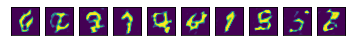

10
Generator Reconstruction Images at 10 Epoch


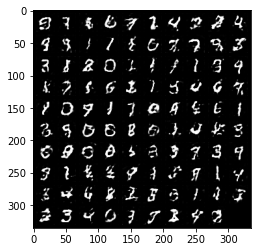

20
Generator Reconstruction Images at 20 Epoch


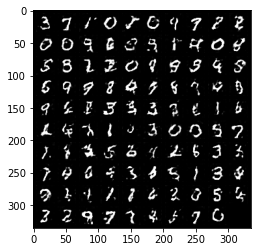

30
Generator Reconstruction Images at 30 Epoch


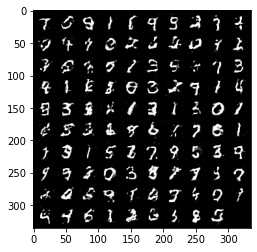

Epoch: [ 2] [ 100/ 468] D_loss: 0.31956810, G_loss: 0.51814324
Epoch: [ 2] [ 200/ 468] D_loss: 0.26325923, G_loss: 0.50764966
Epoch: [ 2] [ 300/ 468] D_loss: 0.30738804, G_loss: 0.49127531
Epoch: [ 2] [ 400/ 468] D_loss: 0.27279526, G_loss: 0.46520162


<Figure size 72x720 with 0 Axes>

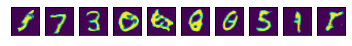

Epoch: [ 3] [ 100/ 468] D_loss: 0.25820673, G_loss: 0.47356093
Epoch: [ 3] [ 200/ 468] D_loss: 0.26029706, G_loss: 0.53714204
Epoch: [ 3] [ 300/ 468] D_loss: 0.20509581, G_loss: 0.49977919
Epoch: [ 3] [ 400/ 468] D_loss: 0.32831997, G_loss: 0.50103134


<Figure size 72x720 with 0 Axes>

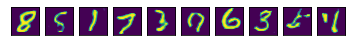

Epoch: [ 4] [ 100/ 468] D_loss: 0.27802563, G_loss: 0.54540133
Epoch: [ 4] [ 200/ 468] D_loss: 0.22755773, G_loss: 0.50751543
Epoch: [ 4] [ 300/ 468] D_loss: 0.36793095, G_loss: 0.32324955
Epoch: [ 4] [ 400/ 468] D_loss: 0.22304884, G_loss: 0.43428931


<Figure size 72x720 with 0 Axes>

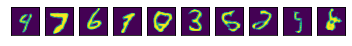

Epoch: [ 5] [ 100/ 468] D_loss: 0.25670058, G_loss: 0.53593904
Epoch: [ 5] [ 200/ 468] D_loss: 0.28482047, G_loss: 0.47777957
Epoch: [ 5] [ 300/ 468] D_loss: 0.22496590, G_loss: 0.48582649
Epoch: [ 5] [ 400/ 468] D_loss: 0.24209118, G_loss: 0.44088334


<Figure size 72x720 with 0 Axes>

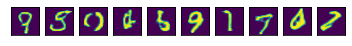

Epoch: [ 6] [ 100/ 468] D_loss: 0.24952433, G_loss: 0.48486385
Epoch: [ 6] [ 200/ 468] D_loss: 0.21778518, G_loss: 0.47773385
Epoch: [ 6] [ 300/ 468] D_loss: 0.36697048, G_loss: 0.49111784
Epoch: [ 6] [ 400/ 468] D_loss: 0.21025810, G_loss: 0.60374379


<Figure size 72x720 with 0 Axes>

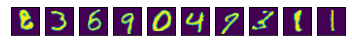

Epoch: [ 7] [ 100/ 468] D_loss: 0.18183050, G_loss: 0.57869238
Epoch: [ 7] [ 200/ 468] D_loss: 0.16372679, G_loss: 0.50787640
Epoch: [ 7] [ 300/ 468] D_loss: 0.29072380, G_loss: 0.49007636
Epoch: [ 7] [ 400/ 468] D_loss: 0.34003091, G_loss: 0.40859729


<Figure size 72x720 with 0 Axes>

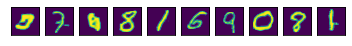

Epoch: [ 8] [ 100/ 468] D_loss: 0.24068420, G_loss: 0.59375930
Epoch: [ 8] [ 200/ 468] D_loss: 0.19703446, G_loss: 0.47633535
Epoch: [ 8] [ 300/ 468] D_loss: 0.25871924, G_loss: 0.52805626
Epoch: [ 8] [ 400/ 468] D_loss: 0.19884682, G_loss: 0.55595762


<Figure size 72x720 with 0 Axes>

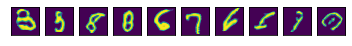

Epoch: [ 9] [ 100/ 468] D_loss: 0.22421135, G_loss: 0.61242962
Epoch: [ 9] [ 200/ 468] D_loss: 0.26705611, G_loss: 0.49455059
Epoch: [ 9] [ 300/ 468] D_loss: 0.21916510, G_loss: 0.63051659
Epoch: [ 9] [ 400/ 468] D_loss: 0.22868569, G_loss: 0.58765095


<Figure size 72x720 with 0 Axes>

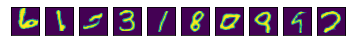

Epoch: [10] [ 100/ 468] D_loss: 0.16939674, G_loss: 0.60569608
Epoch: [10] [ 200/ 468] D_loss: 0.22803795, G_loss: 0.46796554
Epoch: [10] [ 300/ 468] D_loss: 0.18910557, G_loss: 0.55412126
Epoch: [10] [ 400/ 468] D_loss: 0.19720358, G_loss: 0.55425179


<Figure size 72x720 with 0 Axes>

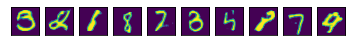

Epoch: [11] [ 100/ 468] D_loss: 0.33191371, G_loss: 0.39491165
Epoch: [11] [ 200/ 468] D_loss: 0.19562271, G_loss: 0.62781882
Epoch: [11] [ 300/ 468] D_loss: 0.17917298, G_loss: 0.55728650
Epoch: [11] [ 400/ 468] D_loss: 0.25733060, G_loss: 0.45301747


<Figure size 72x720 with 0 Axes>

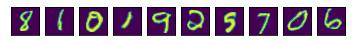

10
Generator Reconstruction Images at 10 Epoch


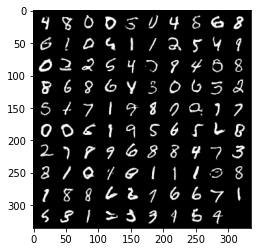

Epoch: [12] [ 100/ 468] D_loss: 0.25516206, G_loss: 0.48463812
Epoch: [12] [ 200/ 468] D_loss: 0.24801654, G_loss: 0.58410919
Epoch: [12] [ 300/ 468] D_loss: 0.15365985, G_loss: 0.59114420
Epoch: [12] [ 400/ 468] D_loss: 0.26473680, G_loss: 0.65301728


<Figure size 72x720 with 0 Axes>

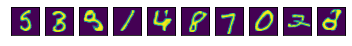

Epoch: [13] [ 100/ 468] D_loss: 0.17728826, G_loss: 0.52819026
Epoch: [13] [ 200/ 468] D_loss: 0.18063651, G_loss: 0.55785489
Epoch: [13] [ 300/ 468] D_loss: 0.23105820, G_loss: 0.46830189
Epoch: [13] [ 400/ 468] D_loss: 0.15511860, G_loss: 0.53169155


<Figure size 72x720 with 0 Axes>

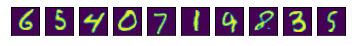

Epoch: [14] [ 100/ 468] D_loss: 0.16548131, G_loss: 0.56962156
Epoch: [14] [ 200/ 468] D_loss: 0.34925371, G_loss: 0.62798381
Epoch: [14] [ 300/ 468] D_loss: 0.25425780, G_loss: 0.53255033
Epoch: [14] [ 400/ 468] D_loss: 0.17765293, G_loss: 0.68433392


<Figure size 72x720 with 0 Axes>

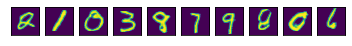

Epoch: [15] [ 100/ 468] D_loss: 0.18372284, G_loss: 0.54108930
Epoch: [15] [ 200/ 468] D_loss: 0.19213569, G_loss: 0.67553246
Epoch: [15] [ 300/ 468] D_loss: 0.28373224, G_loss: 0.60188007
Epoch: [15] [ 400/ 468] D_loss: 0.18669020, G_loss: 0.62279654


<Figure size 72x720 with 0 Axes>

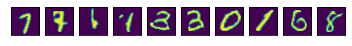

Epoch: [16] [ 100/ 468] D_loss: 0.19697240, G_loss: 0.40167573
Epoch: [16] [ 200/ 468] D_loss: 0.13994825, G_loss: 0.65879738
Epoch: [16] [ 300/ 468] D_loss: 0.16773008, G_loss: 0.65182620
Epoch: [16] [ 400/ 468] D_loss: 0.17840058, G_loss: 0.64637166


<Figure size 72x720 with 0 Axes>

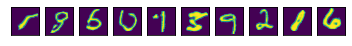

Epoch: [17] [ 100/ 468] D_loss: 0.19523318, G_loss: 0.62164116
Epoch: [17] [ 200/ 468] D_loss: 0.23571174, G_loss: 0.64459527
Epoch: [17] [ 300/ 468] D_loss: 0.13424107, G_loss: 0.59160697
Epoch: [17] [ 400/ 468] D_loss: 0.14681160, G_loss: 0.57874686


<Figure size 72x720 with 0 Axes>

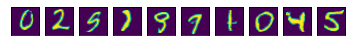

Epoch: [18] [ 100/ 468] D_loss: 0.18230715, G_loss: 0.56129098
Epoch: [18] [ 200/ 468] D_loss: 0.24831441, G_loss: 0.61198890
Epoch: [18] [ 300/ 468] D_loss: 0.15348390, G_loss: 0.66964644
Epoch: [18] [ 400/ 468] D_loss: 0.20989564, G_loss: 0.57734144


<Figure size 72x720 with 0 Axes>

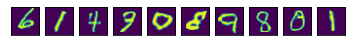

Epoch: [19] [ 100/ 468] D_loss: 0.19626911, G_loss: 0.58336300
Epoch: [19] [ 200/ 468] D_loss: 0.22427231, G_loss: 0.68052101
Epoch: [19] [ 300/ 468] D_loss: 0.18393010, G_loss: 0.58698785
Epoch: [19] [ 400/ 468] D_loss: 0.41750115, G_loss: 0.49422517


<Figure size 72x720 with 0 Axes>

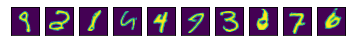

Epoch: [20] [ 100/ 468] D_loss: 0.16888843, G_loss: 0.63175893
Epoch: [20] [ 200/ 468] D_loss: 0.13542259, G_loss: 0.62002987
Epoch: [20] [ 300/ 468] D_loss: 0.16730917, G_loss: 0.66426027
Epoch: [20] [ 400/ 468] D_loss: 0.13681886, G_loss: 0.69084668


<Figure size 72x720 with 0 Axes>

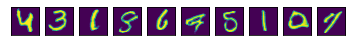

Epoch: [21] [ 100/ 468] D_loss: 0.13717124, G_loss: 0.62226415
Epoch: [21] [ 200/ 468] D_loss: 0.17618485, G_loss: 0.55373460
Epoch: [21] [ 300/ 468] D_loss: 0.24797080, G_loss: 0.54172122
Epoch: [21] [ 400/ 468] D_loss: 0.16447259, G_loss: 0.71601433


<Figure size 72x720 with 0 Axes>

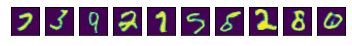

10
Generator Reconstruction Images at 10 Epoch


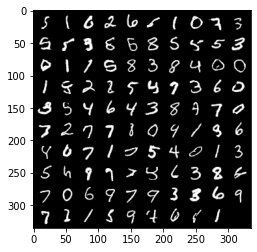

20
Generator Reconstruction Images at 20 Epoch


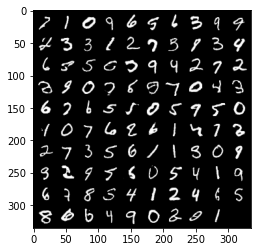

Epoch: [22] [ 100/ 468] D_loss: 0.14469618, G_loss: 0.62018770
Epoch: [22] [ 200/ 468] D_loss: 0.13369849, G_loss: 0.66187322
Epoch: [22] [ 300/ 468] D_loss: 0.23381595, G_loss: 0.44127253
Epoch: [22] [ 400/ 468] D_loss: 0.15491879, G_loss: 0.61862135


<Figure size 72x720 with 0 Axes>

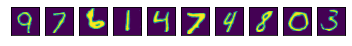

Epoch: [23] [ 100/ 468] D_loss: 0.11924263, G_loss: 0.62924302
Epoch: [23] [ 200/ 468] D_loss: 0.14581312, G_loss: 0.57188845
Epoch: [23] [ 300/ 468] D_loss: 0.19537181, G_loss: 0.62220383
Epoch: [23] [ 400/ 468] D_loss: 0.14787614, G_loss: 0.63596708


<Figure size 72x720 with 0 Axes>

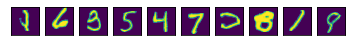

Epoch: [24] [ 100/ 468] D_loss: 0.15841943, G_loss: 0.64197862
Epoch: [24] [ 200/ 468] D_loss: 0.14331496, G_loss: 0.63645184
Epoch: [24] [ 300/ 468] D_loss: 0.12978780, G_loss: 0.66412675
Epoch: [24] [ 400/ 468] D_loss: 0.12111972, G_loss: 0.58981073


<Figure size 72x720 with 0 Axes>

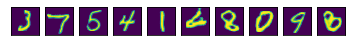

Epoch: [25] [ 100/ 468] D_loss: 0.11686814, G_loss: 0.60438526
Epoch: [25] [ 200/ 468] D_loss: 0.17722782, G_loss: 0.67138463
Epoch: [25] [ 300/ 468] D_loss: 0.15945505, G_loss: 0.61012197
Epoch: [25] [ 400/ 468] D_loss: 0.15171051, G_loss: 0.65697074


<Figure size 72x720 with 0 Axes>

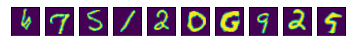

Epoch: [26] [ 100/ 468] D_loss: 0.11385840, G_loss: 0.71810639
Epoch: [26] [ 200/ 468] D_loss: 0.13028219, G_loss: 0.64485633
Epoch: [26] [ 300/ 468] D_loss: 0.12464158, G_loss: 0.69406056
Epoch: [26] [ 400/ 468] D_loss: 0.13492778, G_loss: 0.61709183


<Figure size 72x720 with 0 Axes>

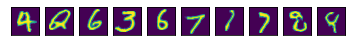

Epoch: [27] [ 100/ 468] D_loss: 0.17977011, G_loss: 0.61818004
Epoch: [27] [ 200/ 468] D_loss: 0.16142277, G_loss: 0.57532418
Epoch: [27] [ 300/ 468] D_loss: 0.16189632, G_loss: 0.62817442
Epoch: [27] [ 400/ 468] D_loss: 0.14346701, G_loss: 0.55451936


<Figure size 72x720 with 0 Axes>

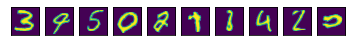

Epoch: [28] [ 100/ 468] D_loss: 0.09531859, G_loss: 0.67806554
Epoch: [28] [ 200/ 468] D_loss: 0.17452830, G_loss: 0.68699926
Epoch: [28] [ 300/ 468] D_loss: 0.17290038, G_loss: 0.72361147
Epoch: [28] [ 400/ 468] D_loss: 0.15472475, G_loss: 0.71628022


<Figure size 72x720 with 0 Axes>

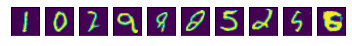

Epoch: [29] [ 100/ 468] D_loss: 0.18112731, G_loss: 0.72171748
Epoch: [29] [ 200/ 468] D_loss: 0.14704353, G_loss: 0.73490125
Epoch: [29] [ 300/ 468] D_loss: 0.17087543, G_loss: 0.58736259
Epoch: [29] [ 400/ 468] D_loss: 0.13477927, G_loss: 0.58179760


<Figure size 72x720 with 0 Axes>

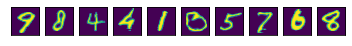

Epoch: [30] [ 100/ 468] D_loss: 0.10121893, G_loss: 0.67915046
Epoch: [30] [ 200/ 468] D_loss: 0.09952393, G_loss: 0.68767381
Epoch: [30] [ 300/ 468] D_loss: 0.15923274, G_loss: 0.57005513
Epoch: [30] [ 400/ 468] D_loss: 0.17547651, G_loss: 0.69322002


<Figure size 72x720 with 0 Axes>

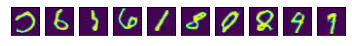

Epoch: [31] [ 100/ 468] D_loss: 0.34714216, G_loss: 0.57603741
Epoch: [31] [ 200/ 468] D_loss: 0.11986105, G_loss: 0.63620400
Epoch: [31] [ 300/ 468] D_loss: 0.19646499, G_loss: 0.60521638
Epoch: [31] [ 400/ 468] D_loss: 0.17506748, G_loss: 0.75376356


<Figure size 72x720 with 0 Axes>

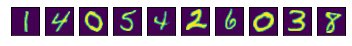

10
Generator Reconstruction Images at 10 Epoch


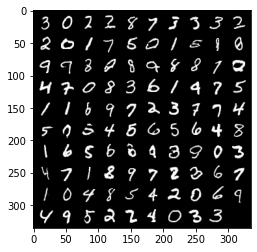

30
Generator Reconstruction Images at 30 Epoch


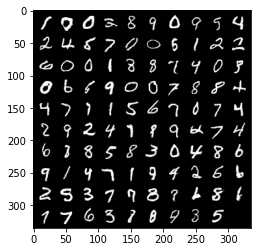

Epoch: [32] [ 100/ 468] D_loss: 0.18051901, G_loss: 0.56987989
Epoch: [32] [ 200/ 468] D_loss: 0.15332666, G_loss: 0.69558454
Epoch: [32] [ 300/ 468] D_loss: 0.17129262, G_loss: 0.59877741
Epoch: [32] [ 400/ 468] D_loss: 0.16978315, G_loss: 0.66099983


<Figure size 72x720 with 0 Axes>

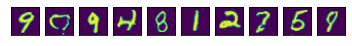

Epoch: [33] [ 100/ 468] D_loss: 0.18788183, G_loss: 0.70365715
Epoch: [33] [ 200/ 468] D_loss: 0.21373528, G_loss: 0.59111792
Epoch: [33] [ 300/ 468] D_loss: 0.15961659, G_loss: 0.47743365
Epoch: [33] [ 400/ 468] D_loss: 0.17975891, G_loss: 0.73742533


<Figure size 72x720 with 0 Axes>

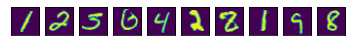

Epoch: [34] [ 100/ 468] D_loss: 0.08563370, G_loss: 0.65625536
Epoch: [34] [ 200/ 468] D_loss: 0.16783541, G_loss: 0.68685508
Epoch: [34] [ 300/ 468] D_loss: 0.13301624, G_loss: 0.67397714
Epoch: [34] [ 400/ 468] D_loss: 0.14275926, G_loss: 0.74972129


<Figure size 72x720 with 0 Axes>

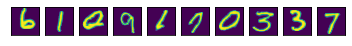

Epoch: [35] [ 100/ 468] D_loss: 0.06829863, G_loss: 0.73495519
Epoch: [35] [ 200/ 468] D_loss: 0.14717400, G_loss: 0.74312580
Epoch: [35] [ 300/ 468] D_loss: 0.10784486, G_loss: 0.70108908
Epoch: [35] [ 400/ 468] D_loss: 0.08262373, G_loss: 0.67147124


<Figure size 72x720 with 0 Axes>

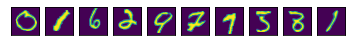

Epoch: [36] [ 100/ 468] D_loss: 0.09447743, G_loss: 0.67316490
Epoch: [36] [ 200/ 468] D_loss: 0.09792414, G_loss: 0.64331937
Epoch: [36] [ 300/ 468] D_loss: 0.15822883, G_loss: 0.59087932
Epoch: [36] [ 400/ 468] D_loss: 0.14809503, G_loss: 0.71943438


<Figure size 72x720 with 0 Axes>

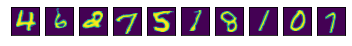

Epoch: [37] [ 100/ 468] D_loss: 0.12405176, G_loss: 0.62431407
Epoch: [37] [ 200/ 468] D_loss: 0.13581473, G_loss: 0.71672058
Epoch: [37] [ 300/ 468] D_loss: 0.13310234, G_loss: 0.68330467
Epoch: [37] [ 400/ 468] D_loss: 0.12363245, G_loss: 0.72326159


<Figure size 72x720 with 0 Axes>

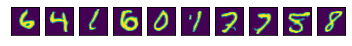

Epoch: [38] [ 100/ 468] D_loss: 0.22694772, G_loss: 0.75620198
Epoch: [38] [ 200/ 468] D_loss: 0.12663813, G_loss: 0.65890825
Epoch: [38] [ 300/ 468] D_loss: 0.12190934, G_loss: 0.64582098
Epoch: [38] [ 400/ 468] D_loss: 0.11033623, G_loss: 0.69969416


<Figure size 72x720 with 0 Axes>

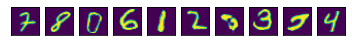

Epoch: [39] [ 100/ 468] D_loss: 0.11337264, G_loss: 0.63127351
Epoch: [39] [ 200/ 468] D_loss: 0.11860447, G_loss: 0.75964683
Epoch: [39] [ 300/ 468] D_loss: 0.08026543, G_loss: 0.71282232
Epoch: [39] [ 400/ 468] D_loss: 0.09497267, G_loss: 0.74201733


<Figure size 72x720 with 0 Axes>

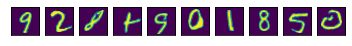

Epoch: [40] [ 100/ 468] D_loss: 0.09765556, G_loss: 0.67226994
Epoch: [40] [ 200/ 468] D_loss: 0.12743199, G_loss: 0.71797884
Epoch: [40] [ 300/ 468] D_loss: 0.14073831, G_loss: 0.69248027
Epoch: [40] [ 400/ 468] D_loss: 0.12815650, G_loss: 0.51328295


<Figure size 72x720 with 0 Axes>

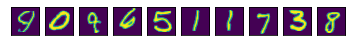

Epoch: [41] [ 100/ 468] D_loss: 0.08899723, G_loss: 0.70114815
Epoch: [41] [ 200/ 468] D_loss: 0.22374237, G_loss: 0.67783666
Epoch: [41] [ 300/ 468] D_loss: 0.13413043, G_loss: 0.72732699
Epoch: [41] [ 400/ 468] D_loss: 0.08891329, G_loss: 0.70723331


<Figure size 72x720 with 0 Axes>

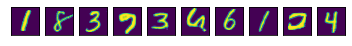

10
Generator Reconstruction Images at 10 Epoch


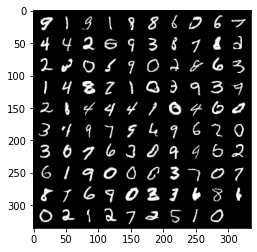

20
Generator Reconstruction Images at 20 Epoch


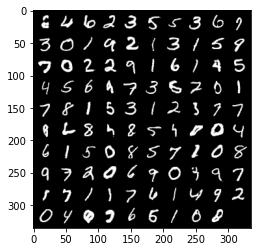

Epoch: [42] [ 100/ 468] D_loss: 0.10692864, G_loss: 0.74643248
Epoch: [42] [ 200/ 468] D_loss: 0.09508929, G_loss: 0.72856313
Epoch: [42] [ 300/ 468] D_loss: 0.17272508, G_loss: 0.65713143
Epoch: [42] [ 400/ 468] D_loss: 0.13901548, G_loss: 0.70801711


<Figure size 72x720 with 0 Axes>

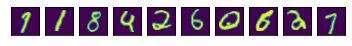

Epoch: [43] [ 100/ 468] D_loss: 0.15377650, G_loss: 0.61911970
Epoch: [43] [ 200/ 468] D_loss: 0.17022482, G_loss: 0.74714684
Epoch: [43] [ 300/ 468] D_loss: 0.11542281, G_loss: 0.70891666
Epoch: [43] [ 400/ 468] D_loss: 0.12400717, G_loss: 0.63077641


<Figure size 72x720 with 0 Axes>

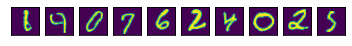

Epoch: [44] [ 100/ 468] D_loss: 0.10324069, G_loss: 0.72993684
Epoch: [44] [ 200/ 468] D_loss: 0.08370623, G_loss: 0.67862087
Epoch: [44] [ 300/ 468] D_loss: 0.15588968, G_loss: 0.75743514
Epoch: [44] [ 400/ 468] D_loss: 0.12139387, G_loss: 0.76568240


<Figure size 72x720 with 0 Axes>

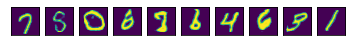

Epoch: [45] [ 100/ 468] D_loss: 0.12063293, G_loss: 0.60096121
Epoch: [45] [ 200/ 468] D_loss: 0.11273481, G_loss: 0.72878355
Epoch: [45] [ 300/ 468] D_loss: 0.12044710, G_loss: 0.66749537
Epoch: [45] [ 400/ 468] D_loss: 0.23000842, G_loss: 0.65939534


<Figure size 72x720 with 0 Axes>

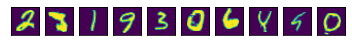

Epoch: [46] [ 100/ 468] D_loss: 0.08183573, G_loss: 0.71272194
Epoch: [46] [ 200/ 468] D_loss: 0.10917232, G_loss: 0.67194533
Epoch: [46] [ 300/ 468] D_loss: 0.11069524, G_loss: 0.60937548
Epoch: [46] [ 400/ 468] D_loss: 0.09996511, G_loss: 0.73724258


<Figure size 72x720 with 0 Axes>

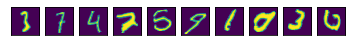

Epoch: [47] [ 100/ 468] D_loss: 0.13077338, G_loss: 0.67446554
Epoch: [47] [ 200/ 468] D_loss: 0.14801477, G_loss: 0.71164709
Epoch: [47] [ 300/ 468] D_loss: 0.08641002, G_loss: 0.74715662
Epoch: [47] [ 400/ 468] D_loss: 0.12351806, G_loss: 0.59528804


<Figure size 72x720 with 0 Axes>

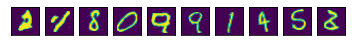

Epoch: [48] [ 100/ 468] D_loss: 0.15596965, G_loss: 0.69673705
Epoch: [48] [ 200/ 468] D_loss: 0.11724964, G_loss: 0.63787025
Epoch: [48] [ 300/ 468] D_loss: 0.18889658, G_loss: 0.58897448
Epoch: [48] [ 400/ 468] D_loss: 0.11359346, G_loss: 0.71823657


<Figure size 72x720 with 0 Axes>

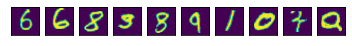

Epoch: [49] [ 100/ 468] D_loss: 0.19141693, G_loss: 0.73736227
Epoch: [49] [ 200/ 468] D_loss: 0.10037071, G_loss: 0.72939247
Epoch: [49] [ 300/ 468] D_loss: 0.08613624, G_loss: 0.74928987
Epoch: [49] [ 400/ 468] D_loss: 0.10778019, G_loss: 0.62257373


<Figure size 72x720 with 0 Axes>

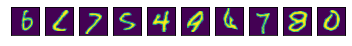

Epoch: [50] [ 100/ 468] D_loss: 0.08637610, G_loss: 0.73262417
Epoch: [50] [ 200/ 468] D_loss: 0.23439337, G_loss: 0.69419408
Epoch: [50] [ 300/ 468] D_loss: 0.11864510, G_loss: 0.72940379
Epoch: [50] [ 400/ 468] D_loss: 0.13314874, G_loss: 0.68731833


<Figure size 72x720 with 0 Axes>

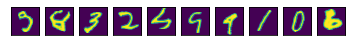

Training finished!


In [12]:
import time
params = {'beta1': 0.05, 'beta2': 0.999,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':50}
params['z_dim'] =100
params['base_size'] = 128

gan = GAN(params)
gan.train()

training start!!
Epoch: [ 1] [ 100/ 468] D_loss: 0.42394337, G_loss: 0.51243865
Epoch: [ 1] [ 200/ 468] D_loss: 0.23068330, G_loss: 0.55403960
Epoch: [ 1] [ 300/ 468] D_loss: 0.20602481, G_loss: 0.54482019
Epoch: [ 1] [ 400/ 468] D_loss: 0.28633395, G_loss: 0.54961979


<Figure size 72x720 with 0 Axes>

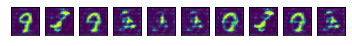

10
Generator Reconstruction Images at 10 Epoch


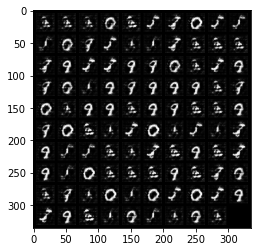

20
Generator Reconstruction Images at 20 Epoch


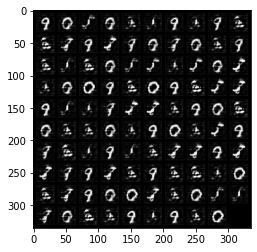

30
Generator Reconstruction Images at 30 Epoch


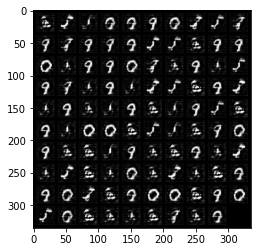

40
Generator Reconstruction Images at 40 Epoch


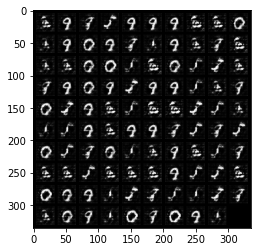

Epoch: [ 2] [ 100/ 468] D_loss: 0.20482242, G_loss: 0.62784404
Epoch: [ 2] [ 200/ 468] D_loss: 0.29960489, G_loss: 0.56825018
Epoch: [ 2] [ 300/ 468] D_loss: 0.19205658, G_loss: 0.57262868
Epoch: [ 2] [ 400/ 468] D_loss: 0.19978948, G_loss: 0.56243193


<Figure size 72x720 with 0 Axes>

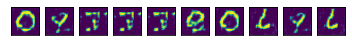

Epoch: [ 3] [ 100/ 468] D_loss: 0.23092189, G_loss: 0.53687298
Epoch: [ 3] [ 200/ 468] D_loss: 0.28123036, G_loss: 0.58797741
Epoch: [ 3] [ 300/ 468] D_loss: 0.34496891, G_loss: 0.68658650
Epoch: [ 3] [ 400/ 468] D_loss: 0.12139076, G_loss: 0.73662615


<Figure size 72x720 with 0 Axes>

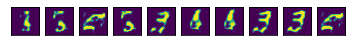

Epoch: [ 4] [ 100/ 468] D_loss: 0.17379670, G_loss: 0.64000976
Epoch: [ 4] [ 200/ 468] D_loss: 0.15577975, G_loss: 0.65495491
Epoch: [ 4] [ 300/ 468] D_loss: 0.33367401, G_loss: 0.58731115
Epoch: [ 4] [ 400/ 468] D_loss: 0.23142633, G_loss: 0.59983873


<Figure size 72x720 with 0 Axes>

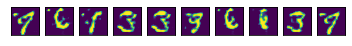

Epoch: [ 5] [ 100/ 468] D_loss: 0.14446706, G_loss: 0.59700531
Epoch: [ 5] [ 200/ 468] D_loss: 0.13302709, G_loss: 0.58787811
Epoch: [ 5] [ 300/ 468] D_loss: 0.17264794, G_loss: 0.57414788
Epoch: [ 5] [ 400/ 468] D_loss: 0.37566775, G_loss: 0.67276788


<Figure size 72x720 with 0 Axes>

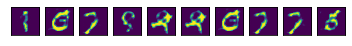

Epoch: [ 6] [ 100/ 468] D_loss: 0.26625526, G_loss: 0.58643496
Epoch: [ 6] [ 200/ 468] D_loss: 0.18611355, G_loss: 0.60110235
Epoch: [ 6] [ 300/ 468] D_loss: 0.10737100, G_loss: 0.70062512
Epoch: [ 6] [ 400/ 468] D_loss: 0.20017816, G_loss: 0.57079911


<Figure size 72x720 with 0 Axes>

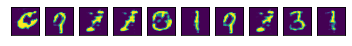

Epoch: [ 7] [ 100/ 468] D_loss: 0.16162834, G_loss: 0.64602315
Epoch: [ 7] [ 200/ 468] D_loss: 0.30899352, G_loss: 0.62385619
Epoch: [ 7] [ 300/ 468] D_loss: 0.17930496, G_loss: 0.61149389
Epoch: [ 7] [ 400/ 468] D_loss: 0.15692842, G_loss: 0.63253677


<Figure size 72x720 with 0 Axes>

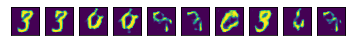

Epoch: [ 8] [ 100/ 468] D_loss: 0.16123965, G_loss: 0.72762036
Epoch: [ 8] [ 200/ 468] D_loss: 0.17169422, G_loss: 0.56925619
Epoch: [ 8] [ 300/ 468] D_loss: 0.20847809, G_loss: 0.57409084
Epoch: [ 8] [ 400/ 468] D_loss: 0.12355305, G_loss: 0.60385501


<Figure size 72x720 with 0 Axes>

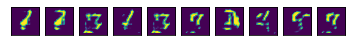

Epoch: [ 9] [ 100/ 468] D_loss: 0.16936643, G_loss: 0.62211823
Epoch: [ 9] [ 200/ 468] D_loss: 0.11484361, G_loss: 0.66459739
Epoch: [ 9] [ 300/ 468] D_loss: 0.13113175, G_loss: 0.60225463
Epoch: [ 9] [ 400/ 468] D_loss: 0.11197826, G_loss: 0.66173393


<Figure size 72x720 with 0 Axes>

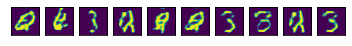

Epoch: [10] [ 100/ 468] D_loss: 0.09143259, G_loss: 0.73463351
Epoch: [10] [ 200/ 468] D_loss: 0.11425608, G_loss: 0.69540107
Epoch: [10] [ 300/ 468] D_loss: 0.18942057, G_loss: 0.61547613
Epoch: [10] [ 400/ 468] D_loss: 0.10642085, G_loss: 0.64263690


<Figure size 72x720 with 0 Axes>

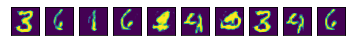

Epoch: [11] [ 100/ 468] D_loss: 0.19138488, G_loss: 0.64638531
Epoch: [11] [ 200/ 468] D_loss: 0.12441349, G_loss: 0.69662166
Epoch: [11] [ 300/ 468] D_loss: 0.09769855, G_loss: 0.72473699
Epoch: [11] [ 400/ 468] D_loss: 0.09094391, G_loss: 0.63170189


<Figure size 72x720 with 0 Axes>

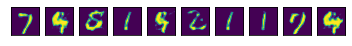

10
Generator Reconstruction Images at 10 Epoch


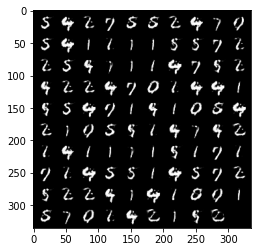

Epoch: [12] [ 100/ 468] D_loss: 0.37738201, G_loss: 0.60462248
Epoch: [12] [ 200/ 468] D_loss: 0.12425144, G_loss: 0.75035143
Epoch: [12] [ 300/ 468] D_loss: 0.08902565, G_loss: 0.67814314
Epoch: [12] [ 400/ 468] D_loss: 0.12890029, G_loss: 0.70022738


<Figure size 72x720 with 0 Axes>

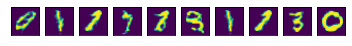

Epoch: [13] [ 100/ 468] D_loss: 0.09062298, G_loss: 0.67141759
Epoch: [13] [ 200/ 468] D_loss: 0.09140112, G_loss: 0.78398520
Epoch: [13] [ 300/ 468] D_loss: 0.04811405, G_loss: 0.80667716
Epoch: [13] [ 400/ 468] D_loss: 0.08808602, G_loss: 0.69582140


<Figure size 72x720 with 0 Axes>

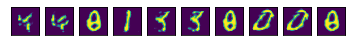

Epoch: [14] [ 100/ 468] D_loss: 0.16479747, G_loss: 0.70799828
Epoch: [14] [ 200/ 468] D_loss: 0.06697682, G_loss: 0.79393429
Epoch: [14] [ 300/ 468] D_loss: 0.10291272, G_loss: 0.69199461
Epoch: [14] [ 400/ 468] D_loss: 0.17165878, G_loss: 0.58916366


<Figure size 72x720 with 0 Axes>

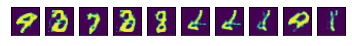

Epoch: [15] [ 100/ 468] D_loss: 0.12765267, G_loss: 0.73156136
Epoch: [15] [ 200/ 468] D_loss: 0.07248739, G_loss: 0.72568244
Epoch: [15] [ 300/ 468] D_loss: 0.11923574, G_loss: 0.71382236
Epoch: [15] [ 400/ 468] D_loss: 0.31807289, G_loss: 0.72197568


<Figure size 72x720 with 0 Axes>

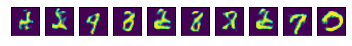

Epoch: [16] [ 100/ 468] D_loss: 0.07853047, G_loss: 0.75221002
Epoch: [16] [ 200/ 468] D_loss: 0.13044833, G_loss: 0.72567928
Epoch: [16] [ 300/ 468] D_loss: 0.19215925, G_loss: 0.75996482
Epoch: [16] [ 400/ 468] D_loss: 0.07404058, G_loss: 0.72261703


<Figure size 72x720 with 0 Axes>

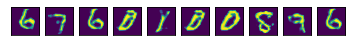

Epoch: [17] [ 100/ 468] D_loss: 0.10634195, G_loss: 0.70755655
Epoch: [17] [ 200/ 468] D_loss: 0.10140851, G_loss: 0.71286023
Epoch: [17] [ 300/ 468] D_loss: 0.13464952, G_loss: 0.73071694
Epoch: [17] [ 400/ 468] D_loss: 0.07781863, G_loss: 0.69072688


<Figure size 72x720 with 0 Axes>

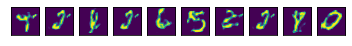

Epoch: [18] [ 100/ 468] D_loss: 0.10365815, G_loss: 0.73044354
Epoch: [18] [ 200/ 468] D_loss: 0.07514803, G_loss: 0.69762969
Epoch: [18] [ 300/ 468] D_loss: 0.15165043, G_loss: 0.70142102
Epoch: [18] [ 400/ 468] D_loss: 0.07428119, G_loss: 0.67402560


<Figure size 72x720 with 0 Axes>

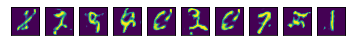

Epoch: [19] [ 100/ 468] D_loss: 0.06145069, G_loss: 0.77236527
Epoch: [19] [ 200/ 468] D_loss: 0.18235001, G_loss: 0.74765885
Epoch: [19] [ 300/ 468] D_loss: 0.24523400, G_loss: 0.48028508
Epoch: [19] [ 400/ 468] D_loss: 0.14087525, G_loss: 0.65549600


<Figure size 72x720 with 0 Axes>

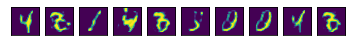

Epoch: [20] [ 100/ 468] D_loss: 0.10038089, G_loss: 0.77231562
Epoch: [20] [ 200/ 468] D_loss: 0.07521718, G_loss: 0.72811341
Epoch: [20] [ 300/ 468] D_loss: 0.13909122, G_loss: 0.72079325
Epoch: [20] [ 400/ 468] D_loss: 0.13039726, G_loss: 0.71244073


<Figure size 72x720 with 0 Axes>

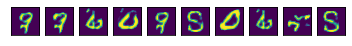

Epoch: [21] [ 100/ 468] D_loss: 0.11885066, G_loss: 0.66469097
Epoch: [21] [ 200/ 468] D_loss: 0.11607540, G_loss: 0.66295099
Epoch: [21] [ 300/ 468] D_loss: 0.16387470, G_loss: 0.68634057
Epoch: [21] [ 400/ 468] D_loss: 0.07126652, G_loss: 0.71171558


<Figure size 72x720 with 0 Axes>

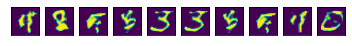

10
Generator Reconstruction Images at 10 Epoch


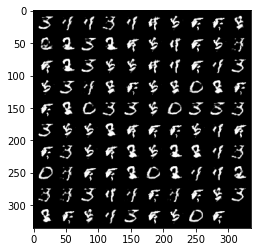

20
Generator Reconstruction Images at 20 Epoch


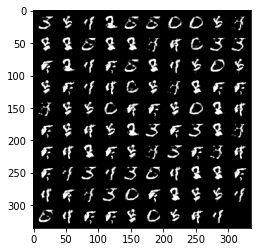

Epoch: [22] [ 100/ 468] D_loss: 0.05205955, G_loss: 0.79724854
Epoch: [22] [ 200/ 468] D_loss: 0.08332309, G_loss: 0.72141862
Epoch: [22] [ 300/ 468] D_loss: 0.22370121, G_loss: 0.75862610
Epoch: [22] [ 400/ 468] D_loss: 0.04928020, G_loss: 0.79982609


<Figure size 72x720 with 0 Axes>

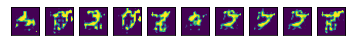

Epoch: [23] [ 100/ 468] D_loss: 0.09229279, G_loss: 0.77111232
Epoch: [23] [ 200/ 468] D_loss: 0.06207824, G_loss: 0.79345995
Epoch: [23] [ 300/ 468] D_loss: 0.08323695, G_loss: 0.80175483
Epoch: [23] [ 400/ 468] D_loss: 0.05996010, G_loss: 0.79857409


<Figure size 72x720 with 0 Axes>

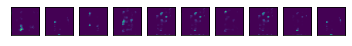

Epoch: [24] [ 100/ 468] D_loss: 0.08032735, G_loss: 0.76512229
Epoch: [24] [ 200/ 468] D_loss: 0.08189450, G_loss: 0.77127427
Epoch: [24] [ 300/ 468] D_loss: 0.39984643, G_loss: 0.22672066
Epoch: [24] [ 400/ 468] D_loss: 0.06389525, G_loss: 0.63220650


<Figure size 72x720 with 0 Axes>

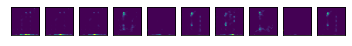

Epoch: [25] [ 100/ 468] D_loss: 0.09187456, G_loss: 0.69640291
Epoch: [25] [ 200/ 468] D_loss: 0.10127270, G_loss: 0.70126712
Epoch: [25] [ 300/ 468] D_loss: 0.08021565, G_loss: 0.58680761
Epoch: [25] [ 400/ 468] D_loss: 0.09647854, G_loss: 0.66537058


<Figure size 72x720 with 0 Axes>

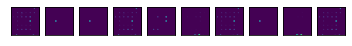

Epoch: [26] [ 100/ 468] D_loss: 0.62138432, G_loss: 0.38451591
Epoch: [26] [ 200/ 468] D_loss: 0.57588792, G_loss: 0.38414592
Epoch: [26] [ 300/ 468] D_loss: 0.07193705, G_loss: 0.72929555
Epoch: [26] [ 400/ 468] D_loss: 0.10741206, G_loss: 0.78543997


<Figure size 72x720 with 0 Axes>

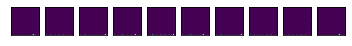

Epoch: [27] [ 100/ 468] D_loss: 0.27892411, G_loss: 0.78386712
Epoch: [27] [ 200/ 468] D_loss: 0.08980712, G_loss: 0.73207343
Epoch: [27] [ 300/ 468] D_loss: 0.05730451, G_loss: 0.73333949
Epoch: [27] [ 400/ 468] D_loss: 0.12103993, G_loss: 0.76809216


<Figure size 72x720 with 0 Axes>

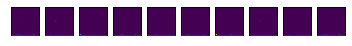

Epoch: [28] [ 100/ 468] D_loss: 0.14052401, G_loss: 0.58974326
Epoch: [28] [ 200/ 468] D_loss: 0.09048580, G_loss: 0.78888535
Epoch: [28] [ 300/ 468] D_loss: 0.07504395, G_loss: 0.76712883
Epoch: [28] [ 400/ 468] D_loss: 0.07291808, G_loss: 0.72706079


<Figure size 72x720 with 0 Axes>

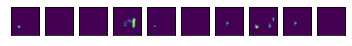

Epoch: [29] [ 100/ 468] D_loss: 0.47933504, G_loss: 0.55200267
Epoch: [29] [ 200/ 468] D_loss: 0.06431238, G_loss: 0.74254453
Epoch: [29] [ 300/ 468] D_loss: 0.07198056, G_loss: 0.76930404
Epoch: [29] [ 400/ 468] D_loss: 0.08344071, G_loss: 0.69097561


<Figure size 72x720 with 0 Axes>

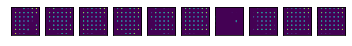

Epoch: [30] [ 100/ 468] D_loss: 0.12143444, G_loss: 0.61376768
Epoch: [30] [ 200/ 468] D_loss: 0.36710209, G_loss: 0.64372164
Epoch: [30] [ 300/ 468] D_loss: 0.16850534, G_loss: 0.56687748
Epoch: [30] [ 400/ 468] D_loss: 0.37951791, G_loss: 0.61226737


<Figure size 72x720 with 0 Axes>

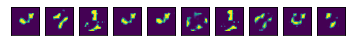

Epoch: [31] [ 100/ 468] D_loss: 0.36520836, G_loss: 0.51880902
Epoch: [31] [ 200/ 468] D_loss: 0.38460860, G_loss: 0.41009822
Epoch: [31] [ 300/ 468] D_loss: 0.34622020, G_loss: 0.50126654
Epoch: [31] [ 400/ 468] D_loss: 0.31898284, G_loss: 0.44517455


<Figure size 72x720 with 0 Axes>

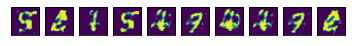

10
Generator Reconstruction Images at 10 Epoch


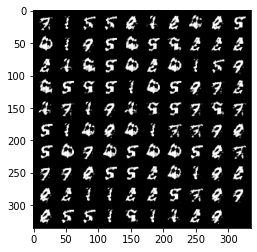

30
Generator Reconstruction Images at 30 Epoch


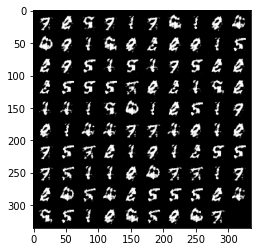

Epoch: [32] [ 100/ 468] D_loss: 0.36393872, G_loss: 0.51472402
Epoch: [32] [ 200/ 468] D_loss: 0.33112168, G_loss: 0.40416184
Epoch: [32] [ 300/ 468] D_loss: 0.33165091, G_loss: 0.37065434
Epoch: [32] [ 400/ 468] D_loss: 0.42305541, G_loss: 0.45029572


<Figure size 72x720 with 0 Axes>

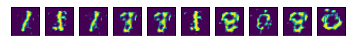

Epoch: [33] [ 100/ 468] D_loss: 0.32696378, G_loss: 0.44455352
Epoch: [33] [ 200/ 468] D_loss: 0.41218877, G_loss: 0.53474963
Epoch: [33] [ 300/ 468] D_loss: 0.29426360, G_loss: 0.51702428
Epoch: [33] [ 400/ 468] D_loss: 0.31085101, G_loss: 0.44992340


<Figure size 72x720 with 0 Axes>

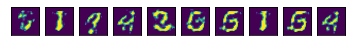

Epoch: [34] [ 100/ 468] D_loss: 0.28898254, G_loss: 0.45783842
Epoch: [34] [ 200/ 468] D_loss: 0.25381798, G_loss: 0.48116273
Epoch: [34] [ 300/ 468] D_loss: 0.31022385, G_loss: 0.46002632
Epoch: [34] [ 400/ 468] D_loss: 0.23142003, G_loss: 0.56562757


<Figure size 72x720 with 0 Axes>

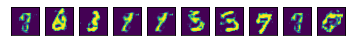

Epoch: [35] [ 100/ 468] D_loss: 0.32494181, G_loss: 0.45718494
Epoch: [35] [ 200/ 468] D_loss: 0.21950829, G_loss: 0.50889397
Epoch: [35] [ 300/ 468] D_loss: 0.24313463, G_loss: 0.47870421
Epoch: [35] [ 400/ 468] D_loss: 0.39776742, G_loss: 0.46629405


<Figure size 72x720 with 0 Axes>

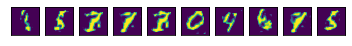

Epoch: [36] [ 100/ 468] D_loss: 0.28692389, G_loss: 0.42609495
Epoch: [36] [ 200/ 468] D_loss: 0.24580765, G_loss: 0.45713609
Epoch: [36] [ 300/ 468] D_loss: 0.30275422, G_loss: 0.44591871
Epoch: [36] [ 400/ 468] D_loss: 0.38289696, G_loss: 0.47316283


<Figure size 72x720 with 0 Axes>

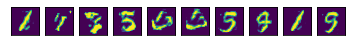

Epoch: [37] [ 100/ 468] D_loss: 0.21247038, G_loss: 0.49013913
Epoch: [37] [ 200/ 468] D_loss: 0.22741614, G_loss: 0.47531646
Epoch: [37] [ 300/ 468] D_loss: 0.23944977, G_loss: 0.55369806
Epoch: [37] [ 400/ 468] D_loss: 0.23349224, G_loss: 0.48516300


<Figure size 72x720 with 0 Axes>

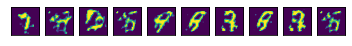

Epoch: [38] [ 100/ 468] D_loss: 0.27398968, G_loss: 0.49182695
Epoch: [38] [ 200/ 468] D_loss: 0.25702864, G_loss: 0.50889885
Epoch: [38] [ 300/ 468] D_loss: 0.22702113, G_loss: 0.45932421
Epoch: [38] [ 400/ 468] D_loss: 0.21315300, G_loss: 0.49836639


<Figure size 72x720 with 0 Axes>

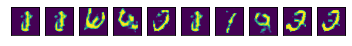

Epoch: [39] [ 100/ 468] D_loss: 0.21558119, G_loss: 0.51183766
Epoch: [39] [ 200/ 468] D_loss: 0.31652629, G_loss: 0.52673775
Epoch: [39] [ 300/ 468] D_loss: 0.27422699, G_loss: 0.51152807
Epoch: [39] [ 400/ 468] D_loss: 0.28754932, G_loss: 0.46878272


<Figure size 72x720 with 0 Axes>

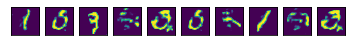

Epoch: [40] [ 100/ 468] D_loss: 0.18078528, G_loss: 0.58096874
Epoch: [40] [ 200/ 468] D_loss: 0.24769045, G_loss: 0.55764550
Epoch: [40] [ 300/ 468] D_loss: 0.17832328, G_loss: 0.54398715
Epoch: [40] [ 400/ 468] D_loss: 0.22366327, G_loss: 0.53984982


<Figure size 72x720 with 0 Axes>

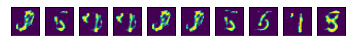

Training finished!


In [19]:
import time
params2 = {'beta1': 0.05, 'beta2': 0.999,'lr_g':0.0002,'lr_d':0.0002,'max_epochs':41}
params2['z_dim'] = 1
params2['base_size'] = 128

gan2 = GAN(params2)
gan2.train()